<a href="https://colab.research.google.com/github/Mohamed2519/Text-Classification-For-SST2-dataset/blob/main/notebook/RNN_CLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Classifier Trained on SST2 Dataset

## Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchtext==0.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 33.3 MB/s 
     |████████████████████████████████| 735.5 MB 14 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.8.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.8.0 which is incompatible.


In [3]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.5 MB/s eta 0:13:03tcmalloc: large alloc 1147494400 bytes == 0x39432000 @  0x7fa256b1b615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████████████████               | 1055.7 MB 48.4 MB/s eta 0:00:20tcmalloc: large alloc 1434370048 bytes == 0x7da88000 @  0x7fa256b1b615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████

In [4]:

import torch
import torch.nn.functional as F
import torchtext
from torchtext.legacy import data
import time
import random
import pandas as pd
print(torchtext.__version__)
torch.backends.cudnn.deterministic = True

0.9.0


## General Settings

In [5]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 10000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

#add path ofcsv files
train_csv_path = '/content/drive/MyDrive/Sentament_analysis SST2/train_binary_sent.csv'
valid_csv_path = '/content/drive/MyDrive/Sentament_analysis SST2/dev_binary_sent.csv'
test_csv_path  = '/content/drive/MyDrive/Sentament_analysis SST2/test_binary_sent.csv'

## Read & Prepare Dataset with Torchtext

Define the Label and Text field formatters:

In [6]:
### Defining the feature processing

TEXT = data.Field(
    tokenize='spacy', # default splits on whitespace
    tokenizer_language='en_core_web_sm'
)

### Defining the label processing

LABEL = data.LabelField(dtype=torch.long)
fields = [('sentence', TEXT), ('label', LABEL)] 


Process the dataset:

In [7]:
train_data = data.TabularDataset(
    path=train_csv_path,
    format='csv',
    fields=fields,
    skip_header=True,
)

for example in train_data.examples:
    print(example.sentence, example.label)
    break

['A', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're', '-', 'imagining', 'of', 'Beauty', 'and', 'the', 'Beast', 'and', '1930s', 'horror', 'films'] pos


In [8]:
valid_data = data.TabularDataset(
    path=valid_csv_path,
    format='csv',
    fields=fields,
    skip_header=True,
)

for example in valid_data.examples:
    print(example.sentence, example.label)
    break

['One', 'long', 'string', 'of', 'cliches', '.'] neg


In [9]:
test_data = data.TabularDataset(
    path=test_csv_path,
    format='csv',
    fields=fields,
    skip_header=True,
)

for example in test_data.examples:
    print(example.sentence, example.label)
    break

['No', 'movement', ',', 'no', 'yuks', ',', 'not', 'much', 'of', 'anything', '.'] neg


In [10]:
print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 6920
Num Validation: 872
Num Test: 1821


## Build Vocabulary

Build the vocabulary based on the top "VOCABULARY_SIZE" words:

In [11]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 10002
Number of classes: 2


Class labels:

In [12]:
print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1})


**Class label count:**

In [13]:
LABEL.vocab.freqs

Counter({'pos': 3610, 'neg': 3310})

## Define Data Loaders

In [14]:
train_loader, valid_loader, test_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size=BATCH_SIZE,
         sort_within_batch=False,
         sort_key=lambda x: len(x.sentence),
         device=DEVICE
    )

Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

In [15]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.sentence.size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.sentence.size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.sentence.size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

Train
Text matrix size: torch.Size([50, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([10, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([7, 128])
Target vector size: torch.Size([128])


## Model

In [16]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [17]:
INPUT_DIM = len(TEXT.vocab)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)


In [18]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

## Training

In [19]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)

            loss2 = F.cross_entropy(logits, targets)
            val_losses.append(loss2.to('cpu'))


            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100 

In [20]:
import matplotlib.pyplot as plt

val_losses = []
train_losses = []
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text = batch_data.sentence.to(DEVICE)
        labels = batch_data.label.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        loss.backward()
        train_losses.append(loss.item())
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, DEVICE)
        val_acc   = compute_accuracy(model, valid_loader, DEVICE)
        print(f'training accuracy: '
              f'{train_acc:.2f}%'
              f'\nvalid accuracy: '
              f'{val_acc:.2f}%')
        print('____________________')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')


Epoch: 001/020 | Batch 000/055 | Loss: 0.7320
Epoch: 001/020 | Batch 050/055 | Loss: 0.6947
training accuracy: 48.28%
valid accuracy: 50.69%
____________________
Time elapsed: 0.01 min
Epoch: 002/020 | Batch 000/055 | Loss: 0.6926
Epoch: 002/020 | Batch 050/055 | Loss: 0.6907
training accuracy: 52.07%
valid accuracy: 50.46%
____________________
Time elapsed: 0.02 min
Epoch: 003/020 | Batch 000/055 | Loss: 0.7078
Epoch: 003/020 | Batch 050/055 | Loss: 0.7034
training accuracy: 52.10%
valid accuracy: 50.34%
____________________
Time elapsed: 0.03 min
Epoch: 004/020 | Batch 000/055 | Loss: 0.6902
Epoch: 004/020 | Batch 050/055 | Loss: 0.7208
training accuracy: 48.06%
valid accuracy: 53.67%
____________________
Time elapsed: 0.04 min
Epoch: 005/020 | Batch 000/055 | Loss: 0.7006
Epoch: 005/020 | Batch 050/055 | Loss: 0.6908
training accuracy: 52.17%
valid accuracy: 49.77%
____________________
Time elapsed: 0.05 min
Epoch: 006/020 | Batch 000/055 | Loss: 0.6835
Epoch: 006/020 | Batch 050/05

In [21]:
test_acc = compute_accuracy(model, test_loader, DEVICE)
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 49.09%


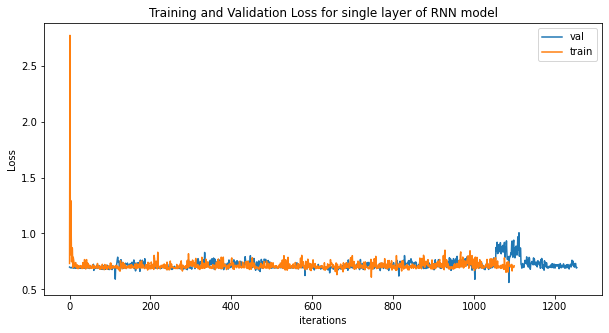

In [22]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for single layer of RNN model")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# Save
PATH='simple_RNN-model.pt'
torch.save(model,PATH)


## Testing

In [24]:

import spacy


nlp = spacy.blank("en")
modell1 = torch.load('/content/simple_RNN-model.pt')
modell1.eval()
def predict_sentiment(model, sentence):

    
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.nn.functional.softmax(modell1(tensor), dim=1)
    return prediction[0][0].item()

print('Probability positive:')
predict_sentiment(modell1, "This is such an good movie, I really love it!")

Probability positive:


0.6950851082801819

In [25]:
print('Probability negative:')
1-predict_sentiment(model, "I really hate this movie. It is really bad and sucks!")

Probability negative:


0.387275755405426